Odessa real estate price predict model

The purpose of this kernel is:

1. Work on the dataset we obtained at the previous stage by parsing the website of the real estate agency:

 - imputation in missing features values
 - encoding of feature values
 - removal of outliers and duplicate features
 - creation of new features based on existing ones, including polynomial
 - filtering multicollinear features in order to reduce their total number

2. Development of predictive models for the optimal explanation of the relationship between the features and the target variable - sale price of apartments, namely:

 - random forest regressor based on basic hyperparameters
 - random forest regressor based on optimal hyperparameters
 - PCA - a model with  additional components based on a random forest model with hyperparameter optimization
 - recursive feature elimination model with cross-validation based on a random forest model with hyperparameter optimization
 - adding clusters based on the k-means model based on a random forest model with hyperparameter optimization

Description of features:

- price - selling price of the apartment
- area - the area of ​​the apartment in square meters
- district - the area where the apartment is located
- floor - the floor of the apartment
- floors - the number of floors in the house
- rooms - number of rooms in the apartment
- type - type of construction project
- cond - general condition of the apartment
- walls - material of the walls of the apartment

In [53]:
### import all necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
from scipy import stats
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

PUNCT_TO_REMOVE = string.punctuation
lemmatizer = WordNetLemmatizer()
SEED=2020
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
le = LabelEncoder()

In [54]:
## loading dataset obtained by us at the previous stage by parsing
df= pd.read_csv(r'odessa_apts_prices_en_2020.csv')
df = df.drop_duplicates() ## drop duplicates from dataset
numcol = df.select_dtypes(include=[np.number]).columns.drop('price')
catcol = df.select_dtypes(include=[np.object]).columns

In [55]:
## inspection of numericals 
df.describe(percentiles=[.25, .5, .75, .9544]).T  ## z-score +/- 2 sigma -  for drop outliers

,count,mean,std,min,25%,50%,75%,95.4%,max
price,6657.0,65688.417176,75745.638192,550.0,35000.0,48490.0,71000.0,170000.000,2000000.0
rooms,6514.0,1.948726,0.917349,1.0,1.0,2.0,3.0,4.000,4.0
floor,6657.0,6.656001,5.436315,1.0,2.0,5.0,9.0,18.000,26.0
floors,6657.0,11.894697,7.098436,1.0,5.0,10.0,17.0,25.000,30.0
area,6641.0,65.485624,39.393466,10.0,42.5,58.0,76.0,132.216,800.0


In [56]:
## splitting dataset for test and train sets
df_train, df_test = train_test_split(df, test_size=0.3, random_state=SEED)

In [57]:
def imputer(df):
    '''*NaN values imputainon to mode for cats and median for nums*'''
    for col in df:
        if col in catcol:
            df.loc[:, col]=df.loc[:, col].fillna(df.loc[:, col].mode()[0])
        else: df.loc[:, col].fillna(df.loc[:, col].median(), inplace=True)
    return df

df_train = imputer(df_train)
df_test = imputer(df_test)

In [58]:
## dataframe before encoding
df_train.sample()


,price,district,rooms,floor,floors,area,type,cond,walls,desc
4858,65000.0,Primorsky,3.0,9,9.0,67.0,Special project,Renovation,Brick,Good renovation from expensive natural materia...


In [59]:
def encoder(df):
    district_category = {'Malinovsky':1, 'Kievsky':2, 'Primorsky':3, 'Suvorovsky':4}
    # Mapping 'district' to group
    df.loc[:, 'district']=df.loc[:, 'district'].map(district_category)
    
    # Bundle rare descriptions with 'Other' category
    df.loc[:,'type'] = df.loc[:,'type'].replace(['Old fund', 'Czech', 'Khrushchevka', 'Stalinka', 'Cellular', 'Belgian', 'Kharkiv', 
                                       'Under construction', 'Moscow', 'Guest', 'Jugoslavsky', 'Private house', 'A small family', 'Renovation',
                                    'After overhaul', 'After builders', 'Residential clean', 'After makeup'], 'Other')
    type_category = {'New ':1, 'Special project':2, 'Other':3}
    df.loc[:, 'type'] = df.loc[:,'type'].map(type_category)
    
    # Bundle rare condition with new categories
    df.loc[:,'cond'] = df.loc[:,'cond'].replace(['Renovation', 'After overhaul', 'After makeup', "Author's design", 'Design Classic', 'Modern design', 'NaN'], 'After renovation') 
    df.loc[:,'cond'] = df.loc[:,'cond'].replace(['After builders', 'Brick', 'Block-brick', "Monolith", 'Blocky', 'Expanded clay-concrete', 'House under construction', 
                                    'Aerated concrete', 'Shell rock', 'Building materials'], 'After builders') 
    df.loc[:,'cond'] = df.loc[:,'cond'].replace(['Need. in cap. renovation', 'Need. in cosm. renovation', 'Need. in tech. renovation'], 'Need renovation') 
    cond_category = {'After renovation':1, 'After builders':2, 'Need renovation':3, 'Residential clean':4}
    df.loc[:,'cond']= df.loc[:,'cond'].map(cond_category)
    
    # Bundle rare walls with new categories
    df.loc[:,'walls'] = df.loc[:,'walls'].replace(['Metal-plastic', 'Metalwork', 'Plastic', "Wood", 'Mixed', 'Reed, dranka ', 'NaN'], 'Other')
    walls_category = {'Brick':1, 'Silicate brick':1, 'Monolith':2, 'Concrete':2, 'Reinforced concrete':2, 'Shell rock':3, 'Shell brick':3, 'Block-brick':4, 'Blocky':4,
                     'Panel': 5, 'Aerated concrete':6, 'Foam concrete':6, 'Expanded clay-concrete': 6, 'Other':7}
    df.loc[:,'walls']=df.loc[:,'walls'].map(walls_category)
    

    return(df)

df_train = encoder(df_train)
df_test = encoder(df_test)

In [60]:
## after encoding
df_train.sample()


,price,district,rooms,floor,floors,area,type,cond,walls,desc
4833,65000.0,3,3.0,1,10.0,73.0,2,1,5,"After renovation, 2 balconies + an extension, ..."


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='area', ylabel='price'>

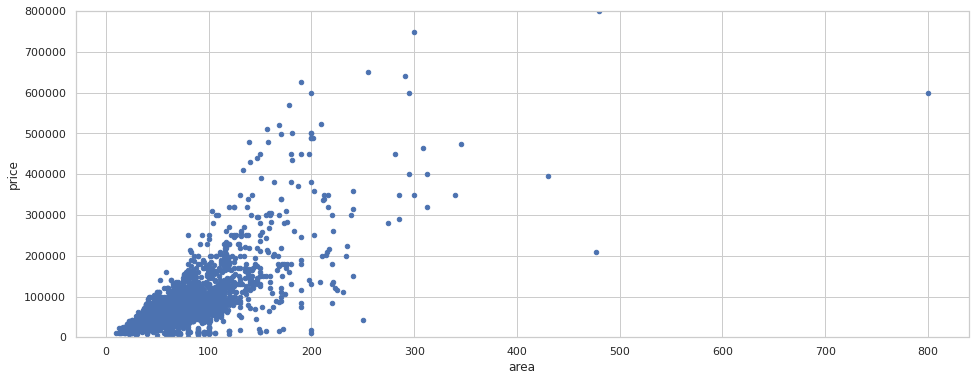

In [61]:
## checking for PRICE and AREA distribution

df_train.plot.scatter(x='area', y='price', figsize=(16, 6), ylim=(0,800000))


In [62]:
def one_value_cols_remover(df):
    ''''remove features with only one value'''
    one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
    df.drop(one_value_cols, axis=1, inplace=True)
    return df

df_train = one_value_cols_remover(df_train)
df_test = one_value_cols_remover(df_test)

In [63]:
## outlier remover

def drop_outliers(df):
    df= df.loc[(df.price<170000) & (df.area<132)] ## as per 95.44% percentile (+/- 2 sigma)
    """
    Returns clear df without outliers based on IQR method
    corresponding to the observations containing more than 2 outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in ['price', 'rooms', 'floor', 'floors', 'area']:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.2 * IQR ## can be increased to 1.7 sometimes
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2)
    print(df.loc[multiple_outliers][['price', 'rooms', 'floor', 'floors', 'area']]) # Show the outliers rows
    # Drop outliers
    df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
    print('Outliers dropped')
    return df

df_train = drop_outliers(df_train)
df_test = drop_outliers(df_test)

         price  rooms  floor  floors    area
6698  110000.0    4.0     21    24.0  115.00
353   110000.0    3.0     22    23.0  107.00
1033  145000.0    3.0     18    22.0  118.00
4220  110000.0    3.0     24    25.0  108.00
6670  115000.0    3.0     25    25.0  123.00
698   116000.0    3.0     18    24.0  111.00
5416  108000.0    4.0     18    25.0  106.40
6365  145200.0    3.0     20    23.0  121.20
3323  165000.0    3.0     18    24.0  121.55
Outliers dropped
        price  rooms  floor  floors   area
113  145000.0    3.0     20    24.0  107.0
Outliers dropped


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='area', ylabel='price'>

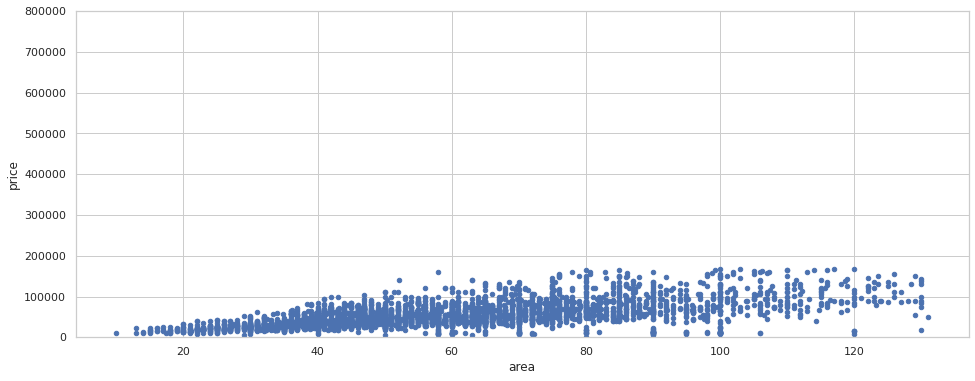

In [64]:
### features after outlier remove
df_train.plot.scatter(x='area', y='price', figsize=(16, 6), ylim=(0,800000))


In [65]:
## polynomial and other features creation

def feature_creator(df):

    
    col = df.columns
    
    #new features based on rooms
    df['is_one_room'] = df['rooms'].map(lambda x: 1 if x == 1 else 0)
    df['is_two_room'] = df['rooms'].map(lambda x: 1 if x == 2 else 0)
    df['is_three_room'] = df['rooms'].map(lambda x: 1 if x == 3 else 0)
    df['is_four_room'] = df['rooms'].map(lambda x: 1 if x == 4 else 0)
    #new features based on floor
    df['is_first_floor'] = df['floor'].map(lambda x: 1 if x == 1 else 0)
    df['is_second_floor'] = df['floor'].map(lambda x: 1 if x == 2 else 0)
    df['is_third_floor'] = df['floor'].map(lambda x: 1 if x == 3 else 0)
    df['more_10_floor'] = df['floor'].map(lambda x: 1 if x >=10 else 0)
    # new features based on floors
    df['is_one_floor'] = df['floors'].map(lambda x: 1 if x == 1 else 0)
    df['upto_5_floors'] = df['floors'].map(lambda x: 1 if (x> 1) and (x <= 5) else 0)
    df['upto_9_floors'] = df['floors'].map(lambda x: 1 if (x> 5) and (x <= 9) else 0)
    df['upto_16_floors'] = df['floors'].map(lambda x: 1 if (x>9) and (x <= 16) else 0)
    df['more_16_floors'] = df['floors'].map(lambda x: 1 if x > 16 else 0)
    # new features based on area
    df['small_area'] = df['area'].map(lambda x: 1 if x<=42.5 else 0)
    df['medium_area'] = df['area'].map(lambda x: 1 if (x> 42.5) and (x <= 76) else 0)
    df['large_area'] = df['area'].map(lambda x: 1 if (x>76) and (x <= 115) else 0)
    df['very_large_area'] = df['area'].map(lambda x: 1 if x > 115 else 0)
    


    for i in numcol:
        
        '''new features creation based on numerical features like as polynomial features, sqrt, log, exp'''
        df[i+'**3'] = df[i]**3
        df[i+'sqrt'] = np.sqrt(df[i])
        df[i+'log']=df[i].apply(lambda x: 0 if (x == 0) else (-np.log(-x) if x < 0 else np.log(x)))
        for j in numcol:
            df[i + "*" + j] = df[i]*df[j]   
            df[i + "/" + j] = df[i]/df[j]
            df[i + "/" + j+'**2'] = (df[i]/df[j])**2
            df[i + "/" + j+'**3'] = (df[i]/df[j])**3


    return df
df_train = feature_creator(df_train)
df_test = feature_creator(df_test) 

In [66]:
## features based on description feature


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def desc_features(df):

    '''return new features based on text desc feature'''
    df['desc_len'] = df['desc'].apply(lambda x: len(str(x)))
    df["desc"] = df["desc"].apply(lambda text: remove_punctuation(text))
    df["desc"] = df["desc"].apply(lambda text: lemmatize_words(text))
    df['near_sea']=df['desc'].str.contains('sea').astype(int)
    df['near_school']=df['desc'].str.contains('school').astype(int)
    df['near_kindergarten']=df['desc'].str.contains('kindergarten').astype(int)          
    df['near_park']=df['desc'].str.contains('park').astype(int)
    df['parking']=df['desc'].str.contains('parking').astype(int)
    df['new']=df['desc'].str.contains('new').astype(int)
    df['with_builtin']=df['desc'].str.contains('builtin').astype(int)
    df['after_renovation']=df['desc'].str.contains('renovation', 'renovated').astype(int)
    df['large']=df['desc'].str.contains('large', 'spacious').astype(int)
    df['good']=df['desc'].str.contains('good', 'excellent').astype(int)
    df.drop('desc', axis=1, inplace=True)
    return df

df_train = desc_features(df_train)
df_test = desc_features(df_test)

In [67]:
def collinearity_filter(df_train, df_test, threshold):
    '''the function accepts train and test datasets and returns datasets without multicollinear features based on train dataset collinear features only'''
    # Absolute value correlation matrix
    corr_matrix = df_train.corr().abs().round(2)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Select columns with Pearson's correlations above threshold
    collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]
    features_filtered = df_train.drop(columns = collinear_features)
    print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])
    features_best = []
    features_best.append(features_filtered.columns.tolist()) ## best features list based on train dataset
    df_train=df_train[features_best[0]] # updated train dataset
    df_test = df_test[features_best[0]] # updated test dataset
    return df_train, df_test

    
df_train, df_test = collinearity_filter(df_train,df_test, 0.9)

The number of features that passed the collinearity threshold:  66


In [68]:
def X_y(df):
    '''X, y - splitter'''
    X = df.drop('price', axis=1).reset_index(drop=True)
    y = np.log1p(df.price)

    return X,y

X_train,y_train = X_y(df_train)  
X_test,y_test = X_y(df_test)  

y_test = np.expm1(y_test)

Mean R2 for train DF: 0.776
R2 for test DF: 0.769
MAE for test DF: 8468.399


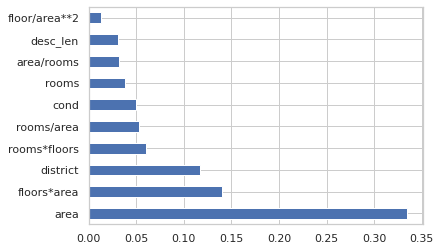

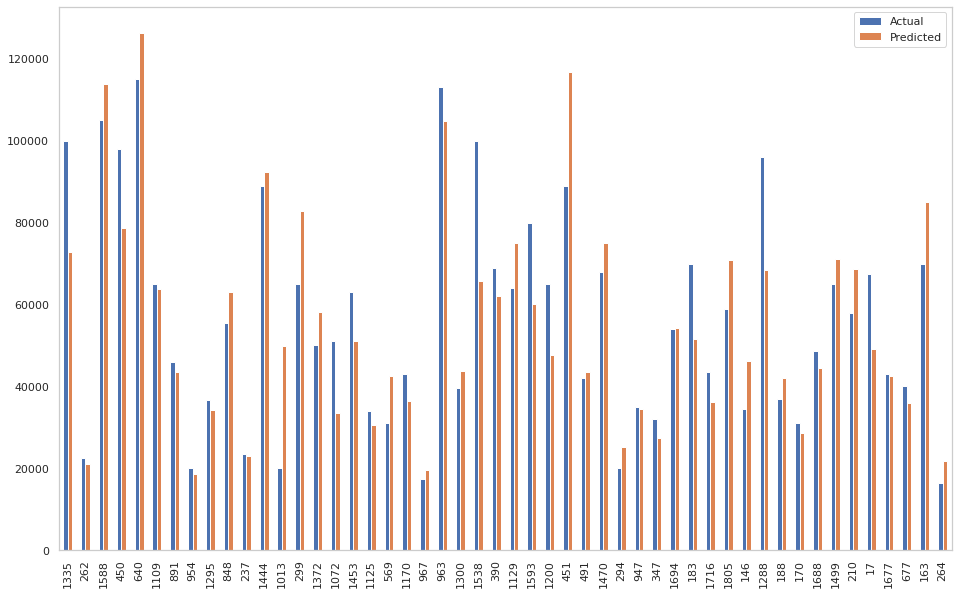

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
def baseline_score(X_train,y_train, X_test, y_test):
    '''takes X,y / returns Mean R2 score 
    and TOP 10 important features based on random forest regressor model'''
    rf = RandomForestRegressor()
    # evaluate model
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(rf, X_train, y_train, scoring='r2', cv=cv)
    # summarize the result
    s_mean = mean(scores)
    rf.fit(X_train, y_train)
    y_pred = np.expm1(rf.predict(X_test))
#     y_pred = rf.predict(X_test)

    importance = rf.feature_importances_
    feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    print ('Mean R2 for train DF: %.3f' % (s_mean))
    print ('R2 for test DF: %.3f' % (r2_score(y_test, y_pred)))
    print ('MAE for test DF: %.3f'% (mean_absolute_error(y_test, y_pred)))
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df = df.sample(50)
    df.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    return rf
    
    
baseline_score(X_train,y_train, X_test, y_test)

{'warm_start': False, 'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.85, 'max_features': 'auto', 'max_depth': 16, 'bootstrap': True}
Mean R2: 0.783
R2 for test DF: 0.759
MAE for test DF: 8636.563


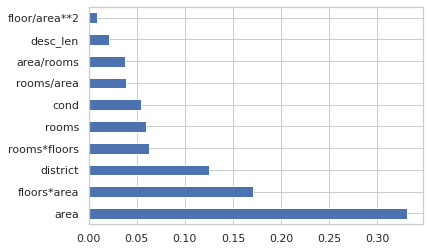

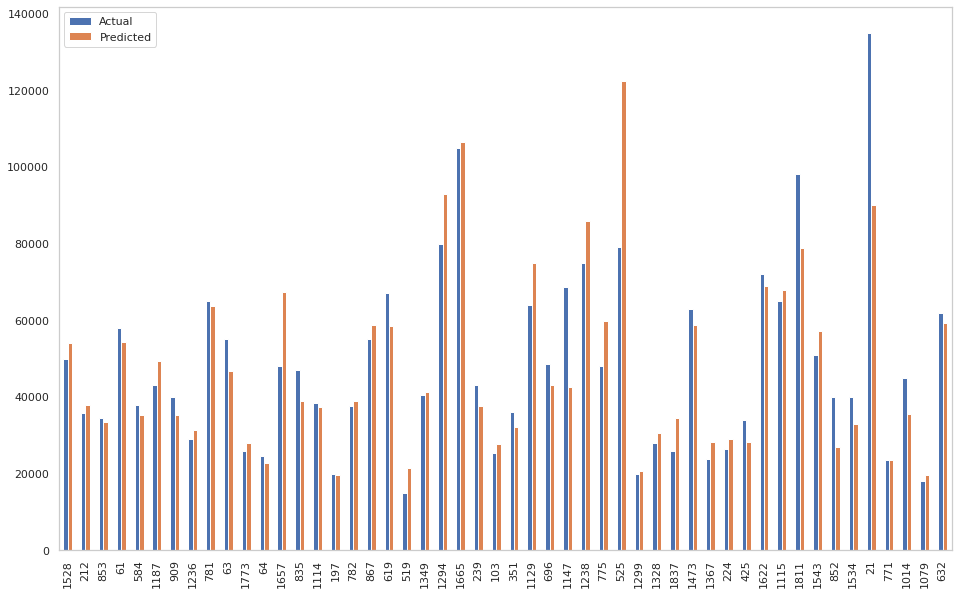

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.85, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=False)

In [70]:
# Searching for optimal hyperparams:

def best_score(X_train,y_train, X_test, y_test):
    rf_grid = RandomForestRegressor(random_state=SEED)
    param_grid = {'bootstrap': [True, False],
     'warm_start': [True, False],
     'max_depth': [8,10,12,14,16],
     'max_features': [2,4,6,8,10,'auto', 'sqrt'],
     'min_samples_leaf': [2,3,4,5],
     'min_samples_split': [2, 3, 4,5],
     'n_estimators': [10,20,30,40,50,60],
     'max_samples': [0.7,0.75,0.8,0.85,0.9,0.95]}
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    grid_search = RandomizedSearchCV(rf_grid, param_grid, cv=cv, scoring='r2',n_iter=30)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    rf_best = grid_search.best_estimator_
    # feature importance
    importance = rf_best.feature_importances_
    feat_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    scores = cross_val_score(rf_best, X_train, y_train, scoring='r2', cv=cv)
    # summarize the result
    s_mean = mean(scores)
    print('Mean R2: %.3f' % (s_mean))
    rf_best.fit(X_train, y_train)
    y_pred = np.expm1(rf_best.predict(X_test))
#     y_pred = rf_best.predict(X_test)

    print('R2 for test DF: %.3f' % (r2_score(y_test, y_pred)))
    print ('MAE for test DF: %.3f'% (mean_absolute_error(y_test, y_pred)))
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df = df.sample(50)
    df.plot(kind='bar',figsize=(16,10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    

    return rf_best

best_score(X_train, y_train, X_test, y_test)

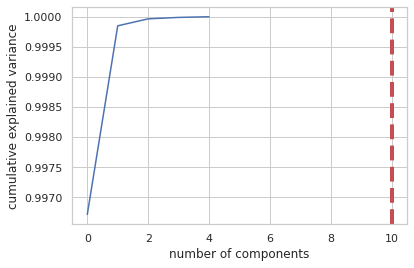

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.996715,0.996715
1,0.999849,0.003134
2,0.999965,0.000116
3,0.999989,0.000024
4,1.000000,0.000011


In [71]:
def pca_plot(X_train):
    pca_test = PCA(n_components=5)
    pca_test.fit(X_train)
    sns.set(style='whitegrid')
    plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
    display()
    evr = pca_test.explained_variance_ratio_
    cvr = np.cumsum(pca_test.explained_variance_ratio_)
    pca_df = pd.DataFrame()
    pca_df['Cumulative Variance Ratio'] = cvr
    pca_df['Explained Variance Ratio'] = evr
    return display(plt.show(), pca_df.head(10))

pca_plot(X_train)

In [72]:
def pca(X_train, X_test):
    '''add first 5 components to X'''
#     scale features between 1 and 0
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(X_train)
    X_scaled_train=pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
    X_scaled_test=pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
    pca = PCA(n_components=5)
    pca.fit(X_scaled_train)
    X_pca_train = pca.transform(X_scaled_train)
    X_pca_test = pca.transform(X_scaled_test)
    pca_data_train=np.vstack((X_pca_train.T)).T
    pca_data_test=np.vstack((X_pca_test.T)).T
    pca_train=pd.DataFrame(data=pca_data_train,columns=("1st Component","2nd Component", "3rd Component", '4th Component', '5th Component'))
    pca_test=pd.DataFrame(data=pca_data_test,columns=("1st Component","2nd Component", "3rd Component", '4th Component', '5th Component'))
    X_pca_train=pd.concat([X_train, pca_train], axis=1)
    X_pca_test=pd.concat([X_test, pca_test], axis=1)
    return X_pca_train, X_pca_test

X_pca_train, X_pca_test = pca(X_train, X_test)

{'warm_start': True, 'n_estimators': 40, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9, 'max_features': 'auto', 'max_depth': 12, 'bootstrap': True}
Mean R2: 0.780
R2 for test DF: 0.759
MAE for test DF: 8713.924


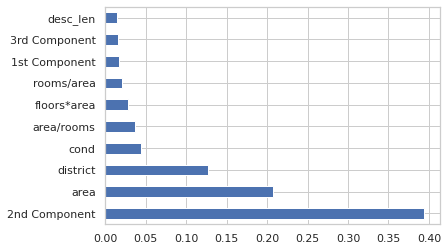

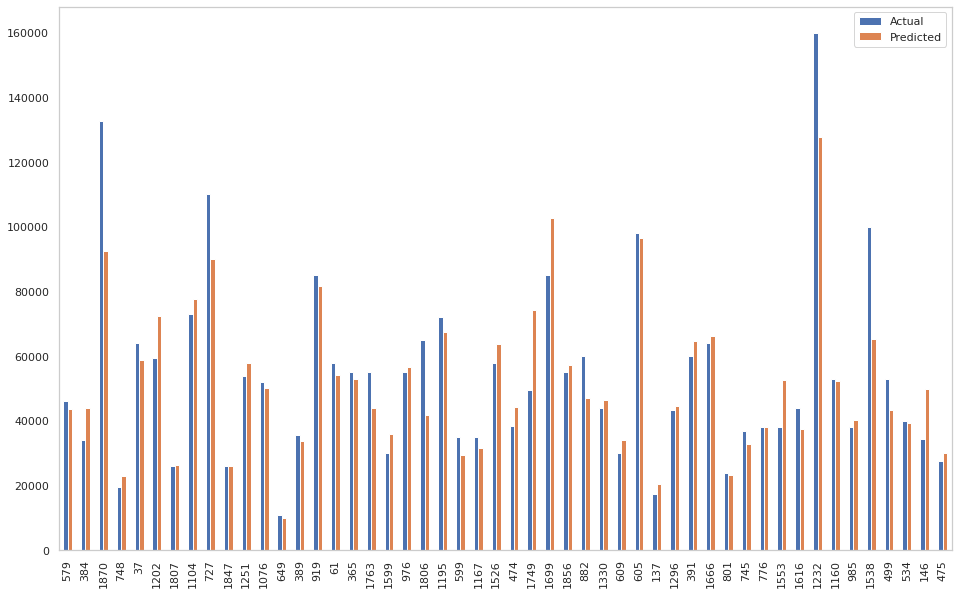

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.9, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=True)

In [73]:
best_score(X_pca_train,y_train, X_pca_test,y_test)


In [74]:
def rfecv(X_train,X_test,y_train):
    regressor = DecisionTreeRegressor(max_depth=12, random_state=SEED)
    selector = RFECV(regressor, step = 1, cv=cv, verbose=1,  scoring='r2')
    selector.fit(X_train, y_train)
    print('The optimal number of features is {}'.format(selector.n_features_))
    features_rfecv = [f for f,s in zip(X_train, selector.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features_rfecv)) ## optimal features list
    X_rfecv_train = X_train[features_rfecv]
    X_rfecv_test = X_test[features_rfecv]
    return X_rfecv_train, X_rfecv_test
X_rfecv_train, X_rfecv_test = rfecv(X_train,X_test,y_train)

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 fe

{'warm_start': True, 'n_estimators': 40, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': False}
Mean R2: 0.781
R2 for test DF: 0.762
MAE for test DF: 8666.837


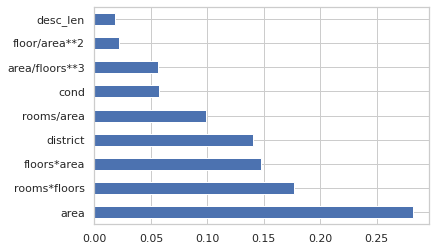

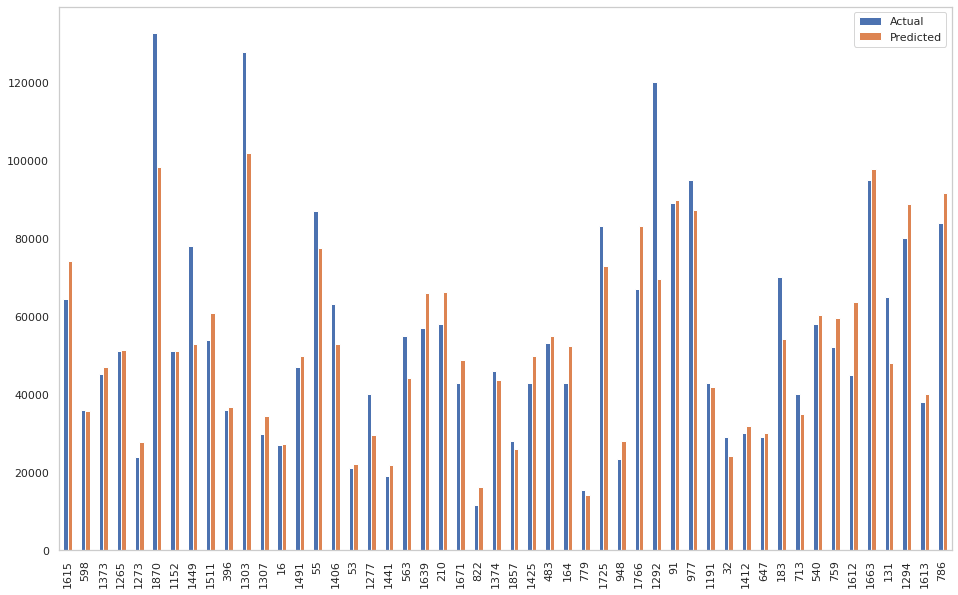

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=0.8, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=True)

In [75]:
best_score(X_rfecv_train,y_train, X_rfecv_test,y_test)

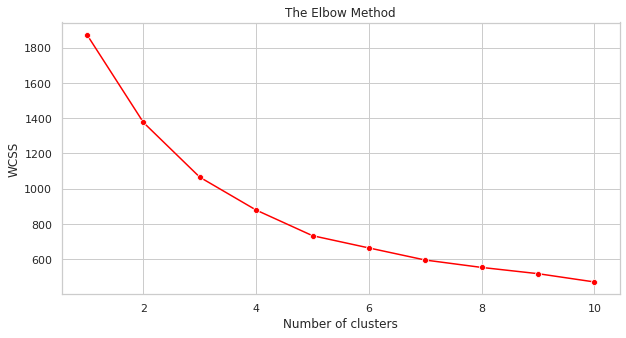

In [76]:
from sklearn.preprocessing import StandardScaler
kmean_features = ['area', 'rooms', 'floors', 'district', 'cond']
# kmean_features = ['rooms*area','floors*area','floor', 'district', "cond"]
X_train_kmean = X_train[kmean_features]
mmscaler = MinMaxScaler()
X_scaled_train_kmean = mmscaler.fit_transform(X_train_kmean)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 5, random_state = SEED)
    kmeans.fit(X_scaled_train_kmean)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [77]:
def kmean(X_train, X_test):
    '''add clusters to X'''
    kmean_features = ['area', 'rooms','floors','floor', 'district', "cond"]
    X_train_kmean = X_train[kmean_features]
    X_test_kmean = X_test[kmean_features]     
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(X_train_kmean)
    X_kmean_scaled_train=scaler.transform(X_train_kmean)
    X_kmean_scaled_test=scaler.transform(X_test_kmean)
    kmeans = KMeans(n_clusters = 5, init = 'k-means++',max_iter = 300, n_init = 10, random_state = SEED)
    kmeans.fit(X_kmean_scaled_train)
    labels_train = pd.DataFrame({'cluster': kmeans.predict(X_kmean_scaled_train)})
    labels_test = pd.DataFrame({'cluster': kmeans.predict(X_kmean_scaled_test)})
    X_kmean_train=pd.concat([X_train, labels_train], axis=1)
    X_kmean_test=pd.concat([X_test, labels_test], axis=1)
    return X_kmean_train, X_kmean_test

X_kmean_train, X_kmean_test = kmean(X_train, X_test)

{'warm_start': True, 'n_estimators': 40, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Mean R2: 0.781
R2 for test DF: 0.754
MAE for test DF: 8687.708


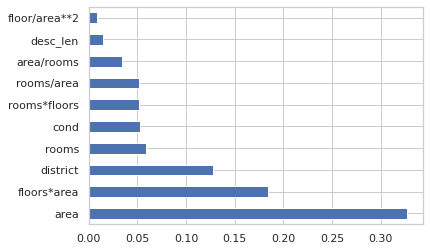

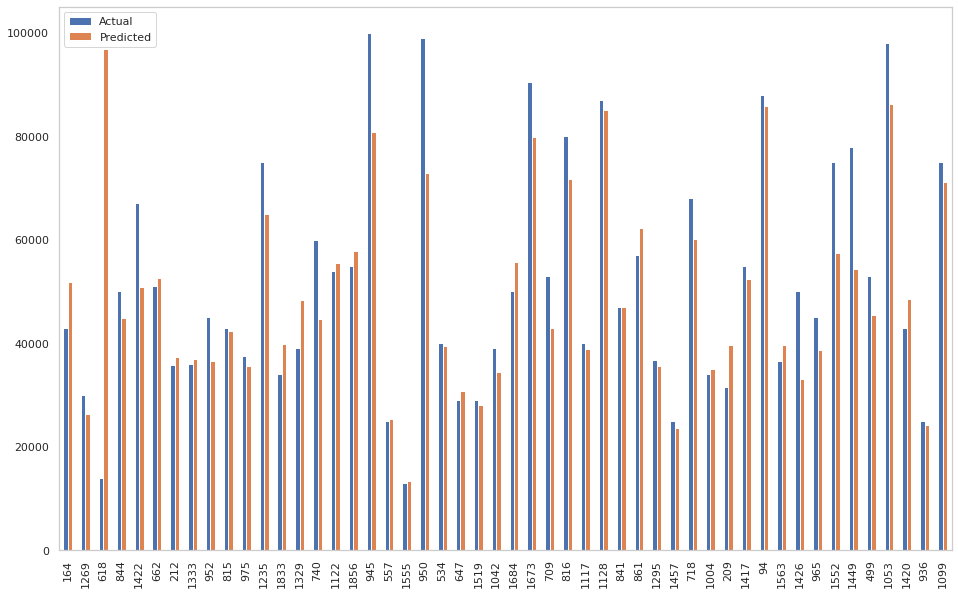

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.8, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=2020, verbose=0, warm_start=True)

In [78]:
best_score(X_kmean_train,y_train, X_kmean_test,y_test)

Conclusions: the optimal version of the model will be considered a random forest regressor model based on basic features and optimal hyperparameters